# The objective: 

### Explore the relationship between bipartisan and the severity of COVID-19

In [255]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm # import statsmodels 
import seaborn as sns
import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
import smogn
from random import sample
import seaborn as sns

%matplotlib inline

# Data transformation

In [256]:
#import dataset
county_data = pd.read_csv('C:/Users/cy/Desktop/COVID-19/data/county_eco_data.csv',dtype={'FIPS':'int'})
party_data = pd.read_csv('C:/Users/cy/Desktop/COVID-19/data/governor-wide.csv')
case_data = pd.read_csv('C:/Users/cy/Desktop/COVID-19/data/us-counties.csv')

In [257]:
party_data['pct'] = party_data['rep']/party_data['total.votes']
party_data = party_data[['fipscode','pct']]

#transform data of new york
county_data = county_data[county_data['Area_Name']!='New York County']
case_data.loc[case_data['county']=='New York City','fips'] = 36000

In [258]:
#change data type
case_data['date'] = pd.to_datetime(case_data['date'])
party_data['fipscode'] = party_data['fipscode'].astype('int')
county_data['FIPS'] = county_data['FIPS'].astype('int')

In [260]:
#get the latest cumulative cases by county
case_static = case_data.groupby('fips',as_index=False)['cases'].max()

In [261]:
#aggregate the party data (some county has same fips)
party_data = party_data.groupby('fipscode',as_index=False).sum()

In [262]:
#merge data
combined_data = case_static.merge(county_data,how='inner',left_on='fips',right_on='FIPS')
combined_data = combined_data.merge(party_data,how='inner',left_on='fips',right_on='fipscode')

In [263]:
#set the earlist data of the covid in US as day 0, and calculate the relative day of the spread for each county
relative_date = (case_data.groupby('fips')['date'].min() - case_data['date'].min()).map(lambda x: int(str(x).split(' ')[0])).reset_index()
relative_date.columns = ['fips','relative_covid_date']

In [264]:
#merge again
combined_data = combined_data.merge(relative_date,left_on='fips',right_on='fips')

In [265]:
#create new columns
combined_data['old_pct'] = combined_data['Total_age65plus']/combined_data['POP_ESTIMATE_2018']
combined_data['hospital_pop'] = combined_data['Total Hospitals (2019)']/combined_data['POP_ESTIMATE_2018']
combined_data['cases_pop'] = combined_data['cases']/combined_data['POP_ESTIMATE_2018']
combined_data['male_pct'] = combined_data['Total_Male']/combined_data['POP_ESTIMATE_2018']

In [266]:
len(combined_data)

1909

In [267]:
#create dummy variable
combined_data['republican'] = combined_data['pct'].map(lambda x: 1 if (x>0.5) else 0)

# Explore the relationship between party and cases_pop

In [268]:
combined_log = combined_data.copy()

#rename columns
combined_log = combined_log.rename(columns = {'Median_Household_Income_2018':'income','Unemployment_rate_2018':'unemp_rate','Mar Temp AVG / F':'temp',
                       'transit_scores - population weighted averages aggregated from town/city level to county':'transit_score','Density per square mile of land area - Population':'density',
                                             'R_INTERNATIONAL_MIG_2018':'immigration'})

In [269]:
#log the data
combined_log['cases_pop'] = np.log(1000000*combined_log['cases_pop'])
combined_log['density_log'] = np.log(combined_log['density'])
combined_log['old_pct_log'] = np.log(combined_log['old_pct'])
combined_log['umemp_log'] = np.log(combined_log['unemp_rate'])

(array([1.835e+03, 4.600e+01, 1.200e+01, 6.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.56455348e-05, 5.40151280e-03, 1.07873801e-02, 1.61732473e-02,
        2.15591146e-02, 2.69449818e-02, 3.23308491e-02, 3.77167164e-02,
        4.31025836e-02, 4.84884509e-02, 5.38743182e-02]),
 <a list of 10 Patch objects>)

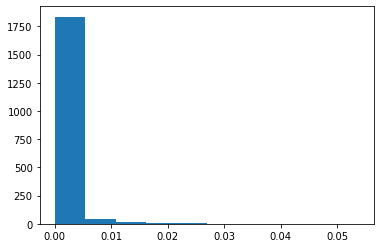

In [270]:
#original data 
plt.hist(combined_data['cases_pop']) #highly right skewed

(array([  5.,  57., 223., 411., 565., 385., 175.,  60.,  21.,   7.]),
 array([ 2.75018556,  3.56460792,  4.37903028,  5.19345264,  6.007875  ,
         6.82229736,  7.63671973,  8.45114209,  9.26556445, 10.07998681,
        10.89440917]),
 <a list of 10 Patch objects>)

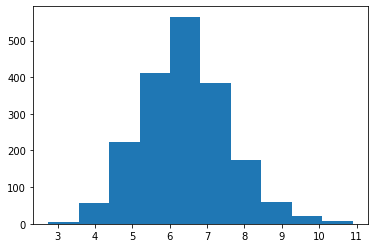

In [271]:
#logged data 
plt.hist(combined_log['cases_pop']) 

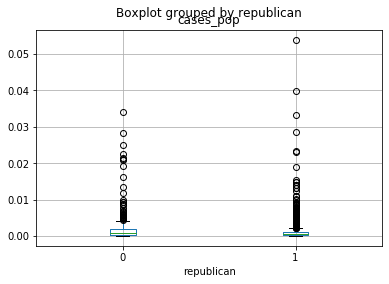

In [272]:
combined_data.boxplot(column=['cases_pop'], by='republican')

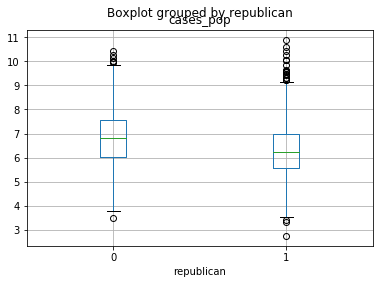

In [273]:
combined_log.boxplot(column=['cases_pop'], by='republican')

In [276]:
#remove outliers

rever_cdf = DataFrame(combined_log['cases_pop'].sort_values()) 
rever_cdf['rank'] = range(1,len(rever_cdf)+1)
rever_cdf['rever_cdf'] = rever_cdf['rank'].map(lambda x: (len(rever_cdf)-x)/len(rever_cdf))
combined_log = pd.concat([combined_log,rever_cdf['rever_cdf']],axis=1)

combined_log = combined_log[(combined_log['rever_cdf']>0.02)&(combined_log['rever_cdf']<0.98)]

(array([ 64., 158., 216., 311., 359., 275., 216., 137.,  60.,  36.]),
 array([4.15977949, 4.65154702, 5.14331456, 5.6350821 , 6.12684964,
        6.61861718, 7.11038472, 7.60215226, 8.0939198 , 8.58568734,
        9.07745488]),
 <a list of 10 Patch objects>)

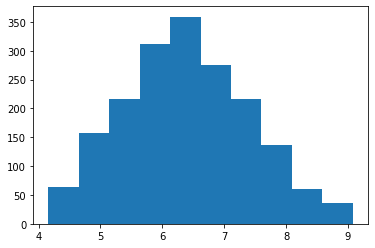

In [277]:
plt.hist(combined_log['cases_pop']) 

In [278]:
len(combined_log)

1832

# Model Establishment

### Regress Case/million to party affiliation

In [279]:
combined_log = combined_log.dropna(subset=['republican','cases_pop','density_log'])

In [280]:
x_var = ['republican','density_log']
X = combined_log[x_var]
Y = combined_log['cases_pop']

# Note the difference in argument order
model = sm.OLS(Y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              cases_pop   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.122e+04
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        18:28:13   Log-Likelihood:                         -3650.7
No. Observations:                1831   AIC:                                      7305.
Df Residuals:                    1829   BIC:                                      7316.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
republican      2.4455      0.076     32.325      0.000       2.297       2.594
density_log     1.0262      0.016     64.741      0.000       0.995       1.057
==============================================================================
Omnibus:                      155.548   Durbin-Watson:                   1.435
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.621
Skew:                           0.735   Prob(JB):                     4.50e-44
Kurtosis:                       3.674   Cond. No.                         7.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""